In [1]:
%tensorflow_version 2.1


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras import layers
import pandas as pd

In [3]:
# Print versions
!python --versions
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)


Numpy 1.23.5
TensorFlow 2.10.0


unknown option --versions
usage: python [option] ... [-c cmd | -m mod | file | -] [arg] ...
Try `python -h' for more information.


In [13]:
folder = './Data_190-1/Data/'
a = pd.read_csv(folder + 'apple.csv')
a['Fruit'] = 0
b = pd.read_csv(folder + 'banana.csv')
b['Fruit'] = 1
o = pd.read_csv(folder + 'orange.csv')
o['Fruit'] = 2
all_data = pd.concat([a,b,o], ignore_index=True)

In [14]:
all_data

,Red,Green,Blue,Fruit
0,0.522,0.261,0.217,0
1,0.522,0.261,0.217,0
2,0.550,0.250,0.200,0
3,0.545,0.227,0.227,0
4,0.556,0.222,0.222,0
...,...,...,...,...
251,0.590,0.282,0.128,2
252,0.605,0.279,0.116,2
253,0.595,0.286,0.119,2
254,0.583,0.292,0.125,2


In [15]:
# Settings
nsamples = len(all_data)     # Number of samples to use as a dataset
val_ratio = 0.2     # Percentage of samples that should be held for validation set
test_ratio = 0.2    # Percentage of samples that should be held for test set
tflite_model_name = 'fruit_model'  # Will be given .tflite suffix
c_model_name = 'fruit_model'       # Will be given .h suffix
np.random.seed(1234)

In [16]:
#shuffle all_data 
all_data = all_data.sample(frac=1)

#separate all_data into the x_values(features) and y_values(labels)

x_values = all_data.drop(['Fruit'], axis=1)
y_values = all_data['Fruit']

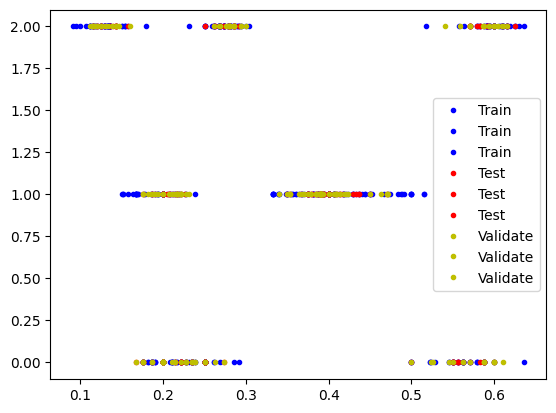

In [17]:
# Plit the dataset into training, validation, and test sets
val_split = int(val_ratio * nsamples)
test_split = int(val_split + (test_ratio * nsamples))
x_val, x_test, x_train = np.split(x_values, [val_split, test_split])
y_val, y_test, y_train = np.split(y_values, [val_split, test_split])

# Check that our splits add up correctly
assert(x_train.size + x_val.size + x_test.size) == nsamples*3

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_val, y_val, 'y.', label="Validate")
plt.legend()
plt.show()

In [27]:
# Create a model
model = tf.keras.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(3,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))

In [28]:
# View model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 16)                64        
                                                                 
 dense_11 (Dense)            (None, 16)                272       
                                                                 
 dense_12 (Dense)            (None, 16)                272       
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Add optimizer, loss function, and metrics to model and compile it
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [30]:
# Train model
history = model.fit(x_train,
                    y_train,
                    epochs=500,
                    batch_size=100,
                    validation_data=(x_val, y_val))

Epoch 1/500
2/2 [==============================] - 2s 461ms/step - loss: 1.2572 - mae: 1.2572 - val_loss: 1.0972 - val_mae: 1.0972
Epoch 2/500
2/2 [==============================] - 0s 47ms/step - loss: 1.2339 - mae: 1.2339 - val_loss: 1.0748 - val_mae: 1.0748
Epoch 3/500
2/2 [==============================] - 0s 130ms/step - loss: 1.2113 - mae: 1.2113 - val_loss: 1.0539 - val_mae: 1.0539
Epoch 4/500
2/2 [==============================] - 0s 123ms/step - loss: 1.1902 - mae: 1.1902 - val_loss: 1.0352 - val_mae: 1.0352
Epoch 5/500
2/2 [==============================] - 0s 121ms/step - loss: 1.1704 - mae: 1.1704 - val_loss: 1.0181 - val_mae: 1.0181
Epoch 6/500
2/2 [==============================] - 0s 141ms/step - loss: 1.1521 - mae: 1.1521 - val_loss: 1.0021 - val_mae: 1.0021
Epoch 7/500
2/2 [==============================] - 0s 153ms/step - loss: 1.1355 - mae: 1.1355 - val_loss: 0.9881 - val_mae: 0.9881
Epoch 8/500
2/2 [==============================] - 0s 114ms/step - loss: 1.1205 - ma

In [31]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\akhil\AppData\Local\Temp\tmpfvazj_p5\assets


4872

In [32]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str


In [33]:

# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))